# Q-learning with neural networks

In [32]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import random
import torch
from pathlib import Path

# For displaying progress bar
from tqdm import tqdm   

import pendulum

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [33]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

**Solution:** Lets create our function:

$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$

In [34]:
# Our state vector x̄ = [ 𝜃 , θ̇ ]; where x = 𝜃 and v =  θ̇ 

def cost(x: np.ndarray, u: int):
    g = 0.01*(1 - np.cos(x[0] - np.pi))**2 + 0.001*x[1]**2 + 0.00001*u**2
    return g

**`torch.nn.MSELoss`**:

- This is the MSE loss class in PyTorch. It computes the mean squared error between the predicted tensor (`output`) and the target tensor (`target`).

- Formula:
  $$
  \text{MSE}(x, y) = \frac{1}{N} \sum_{i=1}^{N} (x_i - y_i)^2
  $$
  where $ x_i $ are predictions, $ y_i $ are targets, and $N$ is the number of samples.


**`torch.optim.SGD`**

- The `SGD` optimizer adjusts the model parameters using the gradient of the loss function.
- It updates the parameters using the rule:

  $$
  \theta \gets \theta - \eta \cdot \nabla L(\theta)
  $$

  where:
  - $\theta$: Parameters of the model (e.g., weights, biases).
  - $\eta$: Learning rate.
  - $\nabla L(\theta)$: Gradient of the loss $L$ w.r.t. the parameters.



In [35]:
# Initialisation
epis_len      = 100
alpha         = 0.99    # Discount Factor
learning_rate = 0.1     # 0.1 is used as the learning rate when our optimizer is SGD
epsilon       = 0.1     # Greedy Policy
max           = 10000

# Our Loss between target and predicted is calculated using mean and optimizer 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(q_function.parameters(), lr=learning_rate)

In [36]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
# random.seed(42)

______________
**Given Algorithm to implement:**


For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$

---

In [38]:
for prgs_bar in tqdm(range(max)):
    
    x_init_np = np.zeros([1,2])
    x_init = torch.tensor(x_init_np, dtype=torch.float32)
    total_cost = 0
    # print(x_init)
        
    for i in range(epis_len):
        
        x = q_function.forward(x_init.unsqueeze(0))
        # print(f"x = {x}")
        
        if torch.rand(1) > epsilon: 
            index = torch.argmin(x).item()
            u = possible_controls[index]
            q_xu = x.squeeze()[index]
        
        else:
            index = torch.randint(0,3,(1,)).item()
            u = possible_controls[index]
            q_xu = x.squeeze()[index]
            
        # print(u)
        # q_xu = np.float64(q_xu)
        
        with torch.no_grad():
                
            state_next = torch.tensor(pendulum.step(x_init.numpy().flatten(), u), dtype=torch.float32)
            y_n    = torch.tensor((cost(x=x_init.numpy().flatten(),u=u) + alpha * torch.min(q_function.forward(state_next.unsqueeze(0))).item()), dtype=torch.float32)
        
        loss = loss_fn(q_xu,y_n)

        # use the optimizer object to zero all of the gradients for the variables it will update,
        # i.e. the weights of the model. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # compute gradient of the loss with respect to model parameters (backward autodiff)
        loss.backward()

        # call the step function of the optimizer to make one update of the parameters
        optimizer.step()
        
        x_init = state_next
        total_cost += cost(x_init.numpy(),  u)
        
        
        

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "RLHW4_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=q_function.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 
        
        

100%|██████████| 10000/10000 [10:35<00:00, 15.74it/s]

Saving model to: models/RLHW4_model.pth


In [46]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=True)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAexJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRJliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07LnY6YnHsOX5sIepwgJjKsAlQNHP/pswOgNHo1QABb0LPkWsFYAAAD
AAADA5Yg+j2rSqIlN/LmgHEisSc2D5sonOO21dc0jGnyZK8eWxUkcGI/ysZagy3E7Te5SBZCoMx/
Ky15hz/WUcDmIJ6nFhT/QANou+MWKo23sVRgo3FPoc8omi1s5YtioT4LLf32Prpv8DlNSbtLxcoD
Cpsa3Wwvm1f4EyoWwLdzNPCoPxPrr11xzkRCgEUI7s1TnIxkPhTM2UhYU0XcYLgngxRXPiNUfJ50
t3DpQPcyHfCB9QeIeRjj+Wp3s91P3xZimf/wwPgxW0bdX243i3LZLiKD3jgPlNNqpclX0vh4Akff
5oMZIRJIhYkZ+NdtApKwK9d1Qz57mshhK+ZFngGlOyuqIgY5ecToJ3PUrx/ZfsAPM2MHakzHXynr
9tgXlWTbnZpNGqHtHevDDhTlOwRAVc3A6//4J7rjrSK92lNBrpnHgLmJzovlEqlk99cHNUGJWtlY
JZj9/ZnsjkOPo6qI9WqoW6sdOVyXEpda1ebAk99LbSv+nGxK71qW0xN3tSwwIsKA82Ht54ZEBUcQ
Z4lp/3KHnETgt72ZYQ8JfABGV6ZQnDlWTRDhaWoRVP06Iz0QhwjmwQAGecna9wp2ZdqNqGxRgKyc
FmNox9gYUMHTMgHFui/a+ojzSqpERgCKMsRwbYz/oG71CLqGXFDYlh1hPHiY/ofHH65GRswwyFNv
kr4B0RXRPfYkqO+2A82dBI/kmn6rXGHYUzu+vmnGwmPtOZnK5vNc9opXnUq5jNQWtQj4W6Jg01lw
FBHDHZTNczQJV1vKdGFoR4p2u8KUs1uGjWEADiFWc1vBv6riaB47NDGax727TVoiWnbaAZ8cIRx9
w2F2Ts+CQALO4AAEnd7hZpyec0iytODThQHtfdDfyFRLhMFg0AlME4Fbv1uRLnn8m+f6+45T1CJU
NNHGfjDWnB6ZesJW7CJ3Rp4qtqHrua7v0ds/YeAcPGaLpKRLdwkeGFatYE1g+8b9eei5txtUnekr
7zyGcj4j+OHOkEjr0AS3MyWhuN2fQyxU2pitPMW088Sl5GiOumgQCvpEk0evGcBlcZlbZfgys5o1
tVqN7HTDVHX5QIw0MOEM6SgruuE9CvwMvHO/8U91tm6F3aduPTp0ViUa2DQh7YS8uVPeMcs3Kl8u
Wwqzo5rRbTEXgTPZ4IEccjRna2sTGms2CTOvY3AVZXalgqUhrJH2ouLQ+ohj7C11R6stbexW+lY3
74BJHPk9G579pfj6Nk0WbKaz8LWPObSsu7UJOuYWSFQyk1DXsTkaypBMXeqRdlWyT3deZdrsV/bR
bm/cjyrzb7BjZm6zfddZm4Fpm2UdMj0RNXD+oenenrYRAH6sR1mdE8lM0lxCMuyM9l2/EAli6uEe
UvxBSfTiCZrb49Wz0fvD+Oc860eG4z1N/a23X8lAIqG57SSxcya8BgrIPX72cix6tBF3oIRVK2xu
4xgkJWhD3i/n/g5tqLvof40dPDuVLoZwDhfHuxCTItmv/Csr3/JWMjuH/tM4x4Cz2BfsbYewuQDg
saf4JolmiSiH4JEJXFqtpnDt4v6p3+GdKtoKKJ7XhSJlC+PTjFt1poAnEEVsyE2wsfXMpB9lGQy2
yKbmuA60pOBIF894JKGgCMlAjgSNpB5VAAIvUWpIf1A2NFhcMuS8AcDzkj7rwCYAAAMAAMGsBbJK
bnAodezBGQ0B9hwV8kQlg/Oc4U4A0Ju6kwEM8uZ9HkJC/aDP0OUCBQ0CMesm7TAO2X9fDbG/pUSy
kVyPCIkdU+uD9FWGAUrDvDKwXb5rIzcDcKjPPAqZ2qQWZuBoEQek4Xh7Clt4iPhO/8eMKYYOCbxz
y/eHCPRu6nnc7WwO6hhRNDGeu57RNWoeL09OfziNK7Gex/TOYyqjVbHy4kjURaGtNRa3FHTOwE8T
vCfYFRnc0VL+6u6yGCZlZzU2Z4buq0yQj/wFX2opFjfqH8YjdaijM367HJG+P4tDJ5UFMsysqc/t
gc8SIUab9XSApbZjw6CqZL6dseNwE/jV/qhI27zdrrK+3HE+VrKySsYEo3XPESF8agSGDSTGdEvd
eItBt2dhDrPkWEPf/iXMKqYWcPODZI0WS5G2UcNcgvUaFSCZSppE0QKm0C88uzA7SaxMfQfwEuQc
jQGY5lRpbIpDaGRPnV4vx

In [45]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=True, save_movie=True)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAvVJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRJliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07LnY6YnHsOX5sIepwgJjKsAlQNHP/pswOgNHo1QABb0LPkWsFYAAAD
AAADA5Yg+j2rSqIlN/LmgHEisSc2D5sonOO21dc0jGnyZK8eWxUkcGI/ysZagy3E7Te5SBZCoMx/
Ky15hz/WUcDmIJ6nFhT/QANou+MWKo23sVRgo3FPoc8omi1s5YtioT4LLf32Prpv8DlNSbtLxcoD
Cpsa3Wwvm1f4EyoWwLdzNPCoPxPrr11xzkRCgEUI7s1TnIxkPhTM2UhYU0XcYLgngxRXPiNUfJ50
t3DpQPcyHfCB9QeIeRjj+Wp3s91P3xZimf/wwPgxW0bdX243i3LZLiKD3jgPlNNqpclX0vh4Akff
5oMZIRJIhYkZ+NdtApKwK9d1Qz57mshhK+ZFngGlOyuqIgY5ecToJ3PUrx/ZfsAPM2MHakzHXynr
9tgXlWTbnZpNGqHtHevDDhTlOwRAVc3A6//4J7rjrSK92lNBrpnHgLmJzovlEqlk99cHNUGJWtlY
JZj9/ZnsjkOPo6qI9WqoW6sdOVyXEpda1ebAk99LbSv+nGxK71qW0xN3tSwwIsKA82Ht54ZEBUcQ
Z4lp/3KHnETgt72ZYQ8JfABGV6ZQnDlWTRDhaWoRVP06Iz0QhwjmwQAGecna9wp2ZdqNqGxRgKyc
FmNox9gYUMHTMgHFui/a+ojzSqpERgCKMsRwbYz/oG71CLqGXFDYlh1hPHiY/ofHH65GRswwyFNv
kr4B0RXRPfYkqO+2A82dBI/kmn6rXGHYUzu+vmnGwmPtOZnK5vNc9opXnUq5jNQWtQj4W6Jg01lw
FBHDHZTNczQJV1vKdGFoR4p2u8KUs1uGjWEADiFWc1vBv6riaB47NDGax727TVoiWnbaAZ8cIRx9
w2F2Ts+CQALO4AAEnd7hZpyec0iytODThQHtfdDfyFRLhMFg0AlME4Fbv1uRLnn8m+f6+45T1CJU
NNHGfjDWnB6ZesJW7CJ3Rp4qtqHrua7v0ds/YeAcPGaLpKRLdwkeGFatYE1g+8b9eei5txtUnekr
7zyGcj4j+OHOkEjr0AS3MyWhuN2fQyxU2pitPMW088Sl5GiOumgQCvpEk0evGcBlcZlbZfgys5o1
tVqN7HTDVHX5QIw0MOEM6SgruuE9CvwMvHO/8U91tm6F3aduPTp0ViUa2DQh7YS8uVPeMcs3Kl8u
Wwqzo5rRbTEXgTPZ4IEccjRna2sTGms2CTOvY3AVZXalgqUhrJH2ouLQ+ohj7C11R6stbexW+lY3
74BJHPk9G579pfj6Nk0WbKaz8LWPObSsu7UJOuYWSFQyk1DXsTkaypBMXeqRdlWyT3deZdrsV/bR
bm/cjyrzb7BjZm6zfddZm4Fpm2UdMj0RNXD+oenenrYRAH6sR1mdE8lM0lxCMuyM9l2/EAli6uEe
UvxBSfTiCZrb49Wz0fvD+Oc860eG4z1N/a23X8lAIqG57SSxcya8BgrIPX72cix6tBF3oIRVK2xu
4xgkJWhD3i/n/g5tqLvof40dPDuVLoZwDhfHuxCTItmv/Csr3/JWMjuH/tM4x4Cz2BfsbYewuQDg
saf4JolmiSiH4JEJXFqtpnDt4v6p3+GdKtoKKJ7XhSJlC+PTjFt1poAnEEVsyE2wsfXMpB9lGQy2
yKbmuA60pOBIF894JKGgCMlAjgSNpB5VAAIvUWpIf1A2NFhcMuS8AcDzkj7rwCYAAAMAAMGsBbJK
bnAodezBGQ0B9hwV8kQlg/Oc4U4A0Ju6kwEM8uZ9HkJC/aDP0OUCBQ0CMesm7TAO2X9fDbG/pUSy
kVyPCIkdU+uD9FWGAUrDvDKwXb5rIzcDcKjPPAqZ2qQWZuBoEQek4Xh7Clt4iPhO/8eMKYYOCbxz
y/eHCPRu6nnc7WwO6hhRNDGeu57RNWoeL09OfziNK7Gex/TOYyqjVbHy4kjURaGtNRa3FHTOwE8T
vCfYFRnc0VL+6u6yGCZlZzU2Z4buq0yQj/wFX2opFjfqH8YjdaijM367HJG+P4tDJ5UFMsysqc/t
gc8SIUab9XSApbZjw6CqZL6dseNwE/jV/qhI27zdrrK+3HE+VrKySsYEo3XPESF8agSGDSTGdEvd
eItBt2dhDrPkWEPf/iXMKqYWcPODZI0WS5G2UcNcgvUaFSCZSppE0QKm0C88uzA7SaxMfQfwEuQc
jQGY5lRpbIpDaGRPnV4vx

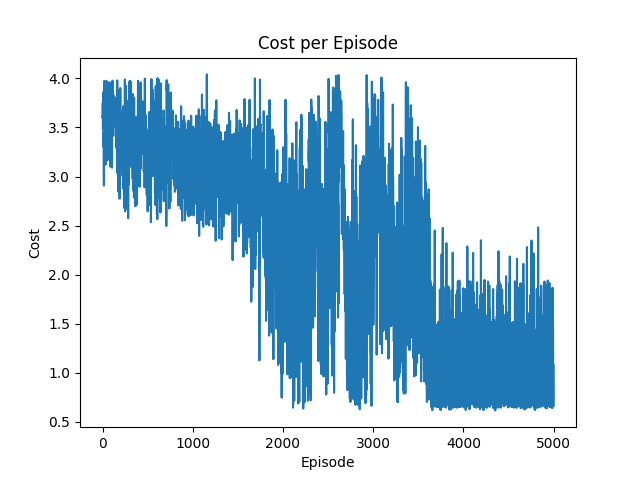

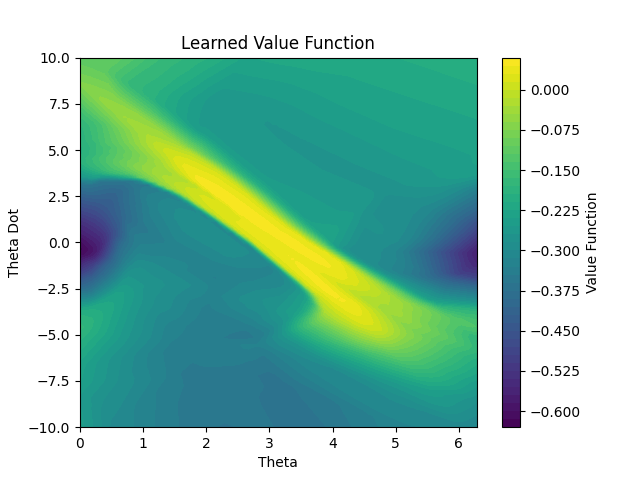

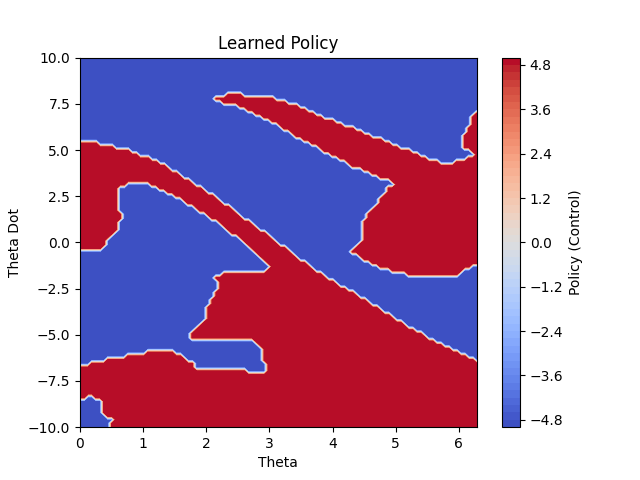

In [48]:
cost_per_episode = np.load('/home/jithin/Desktop/RL_HW4/optlearningcontrol/Homework/Series4/new/series_4_files/cost_per_episode.npy')
# Plot cost per episode
plt.figure()
plt.plot(cost_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.title('Cost per Episode')
plt.show()

# Plot learned value function and policy
theta_vals = np.linspace(0, 2 * np.pi, 100)
theta_dot_vals = np.linspace(-10, 10, 100)
Theta, ThetaDot = np.meshgrid(theta_vals, theta_dot_vals)

ValueFunction = np.zeros_like(Theta)
Policy = np.zeros_like(Theta)

with torch.no_grad():
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            xi = torch.tensor([Theta[i, j], ThetaDot[i, j]],
                                dtype=torch.float)
            q_values = q_function(xi.unsqueeze(0)).cpu().numpy().squeeze()
            # Negative because it's a cost
            ValueFunction[i, j] = -np.min(q_values)
            Policy[i, j] = possible_controls[np.argmin(q_values)]

# Plot the value function
plt.figure()
plt.contourf(Theta, ThetaDot, ValueFunction, levels=50, cmap='viridis')
plt.colorbar(label='Value Function')
plt.xlabel('Theta')
plt.ylabel('Theta Dot')
plt.title('Learned Value Function')
plt.show()

# Plot the policy
plt.figure()
plt.contourf(Theta, ThetaDot, Policy, levels=50, cmap='coolwarm')
plt.colorbar(label='Policy (Control)')
plt.xlabel('Theta')
plt.ylabel('Theta Dot')
plt.title('Learned Policy')
plt.show()